This notebook will walk through some of the analysis that we did using Pythia12B on the MATH dataset.

In [1]:
import sys
import os
import src.analyze as analyze
import src.stats_utils as stats_utils
import src.mixtures as mixtures
import src.better_optimiation as bopt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import src.EM as EM
import src.better_em as BEM
import heapq
import src.bem_geometric as bemg

/Users/jkazdan/miniforge3/envs/finance/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import importlib

importlib.reload(bopt)
importlib.reload(stats_utils)
importlib.reload(mixtures)
importlib.reload(BEM)
importlib.reload(bemg)
importlib.reload(EM)

<module 'src.EM' from '/Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/src/EM.py'>

In [3]:
# get data for the number of math problems solved
data = analyze.create_or_load_large_language_monkeys_pythia_math_pass_at_k_df()

# this tells us whether each attempt was a success or failure -- I don't think it adds any
# value given that the attempts were independent
individual_data = (
    analyze.create_or_load_large_language_monkeys_pythia_math_individual_outcomes_df()
)

Loaded /Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/data/processed_data/large_language_monkeys_pythia_math_pass_at_k.parquet with shape:  (90496, 7)
Loaded /Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/data/processed_data/large_language_monkeys_pythia_math_individual_outcomes.parquet with shape:  (8960000, 5)


In [4]:
# label the number of total samples and compute the number of correct attempts for each problem
data["Num. Samples Total"] = 10000
data["Num. Samples Correct"] = data["Score"] * data["Num. Samples Total"]
data = data[data["Scaling Parameter"] == 1]

In [5]:
# let's start by looking at the math dataset
math_data = data[data["Benchmark"] == "MATH"]

In [6]:
# let's look at Pythia12B only
model_name = "Pythia 12B"
# scaling_parameter =
pythia12_math = math_data[(math_data["Model"] == model_name)]

In [7]:
pythia12_math

,Score,Scaling Parameter,Problem Idx,Model,Benchmark,Log Score,Neg Log Score,Num. Samples Total,Num. Samples Correct
0,0.0122,1,0,Pythia 12B,MATH,-4.406319,4.406319,10000,122.0
1,0.0032,1,1,Pythia 12B,MATH,-5.744604,5.744604,10000,32.0
2,0.0167,1,2,Pythia 12B,MATH,-4.092347,4.092347,10000,167.0
3,0.0001,1,3,Pythia 12B,MATH,-9.210340,9.210340,10000,1.0
4,0.2227,1,4,Pythia 12B,MATH,-1.501930,1.501930,10000,2227.0
...,...,...,...,...,...,...,...,...,...
123,0.0196,1,123,Pythia 12B,MATH,-3.932226,3.932226,10000,196.0
124,0.0000,1,124,Pythia 12B,MATH,-inf,inf,10000,0.0
125,0.0000,1,125,Pythia 12B,MATH,-inf,inf,10000,0.0
126,0.0001,1,126,Pythia 12B,MATH,-9.210340,9.210340,10000,1.0


A brief overview of the fitting methods:
- The two parameter beta distribution is fit on estimated probabilities using scipy
- The three parameter beta distribution is again fit with scipy using an estimated scale parameter given by highest_observed_success_rate*(num_samples+1)/num_samples.  Although this choice of scale parameter would cause make the likelihood under this model of observing higher pass@1 on a new question 0.  Therefore, this model is bad when trying to extrapolate to a test set of witheld problems, but good when estimating scaling laws (because if we don't observe a single success for a given question in 10,000 samples, it's unlikely that the true pass@1 is higher than 22.7%)  This is more of a problem if we specifically care about estimating the distribution rather than the power law, or if we have fewer samples.
- The discretized beta distribution: We bin the success probabilities before fitting the beta distribution directly on the fitted probabilities.  The binning occurs on a log scale to prioritize fitting the left tail of the distribution accurately.  This fit is designed for estimating power laws in the low-sample regime.  

In [8]:
beta_2_params = (
    analyze.fit_beta_binomial_two_parameters_to_num_samples_and_num_successes(
        pythia12_math
    )
)
beta_2_params_stable = bopt.fit_beta_binomial_two_parameters_stable(pythia12_math)
beta_3_params = beta_2_params_stable  # analyze.fit_beta_binomial_three_parameters_to_num_samples_and_num_successes(pythia12_math, maxiter=15)
beta_3_discretized_params = (
    analyze.fit_discretized_beta_three_parameters_to_num_samples_and_num_successes(
        pythia12_math
    )
)  #

/Users/jkazdan/miniforge3/envs/finance/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [9]:
# result of fitting a 2-parameter beta
beta_2_params

alpha                 0.5
beta                  3.5
loc                   0.0
scale                 1.0
neg_log_likelihood    NaN
aic                   NaN
bic                   NaN
Power Law Exponent    0.5
dtype: float64

In [10]:
beta_2_params_stable

alpha                 0.010000
beta                  3.534858
loc                   0.000000
scale                 1.000000
neg_log_likelihood    0.010118
aic                   4.020236
bic                   9.724297
Power Law Exponent    0.010000
dtype: float64

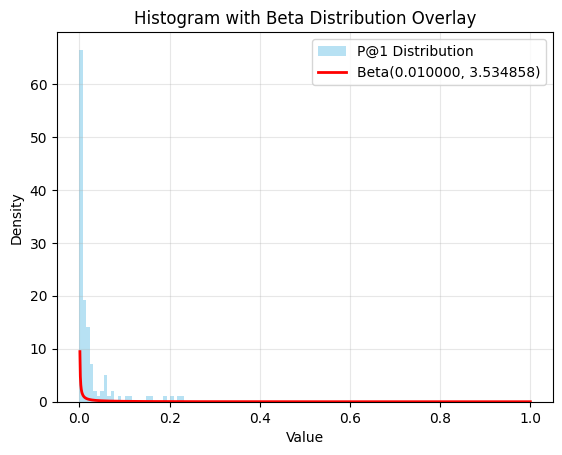

In [11]:
stats_utils.plot_histo_and_beta(pythia12_math["Score"], beta_2_params_stable)

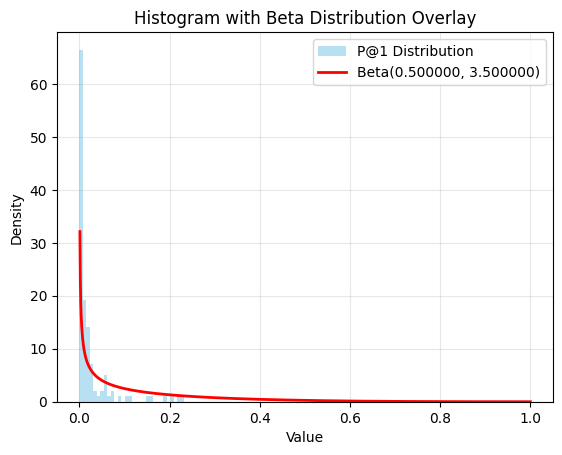

In [12]:
stats_utils.plot_histo_and_beta(pythia12_math["Score"], beta_2_params)

Both of the 3-parameter beta fits work comparably when we are fitting large amounts of data.

In [13]:
print("Beta 3 params")
print(beta_3_params)
print("Beta 3 params discretized")
print(beta_3_discretized_params)

Beta 3 params
alpha                 0.010000
beta                  3.534858
loc                   0.000000
scale                 1.000000
neg_log_likelihood    0.010118
aic                   4.020236
bic                   9.724297
Power Law Exponent    0.010000
dtype: float64
Beta 3 params discretized
alpha                 0.228083
beta                  1.570661
loc                        0.0
scale                   0.2328
neg_log_likelihood    0.763942
success                Success
dtype: object


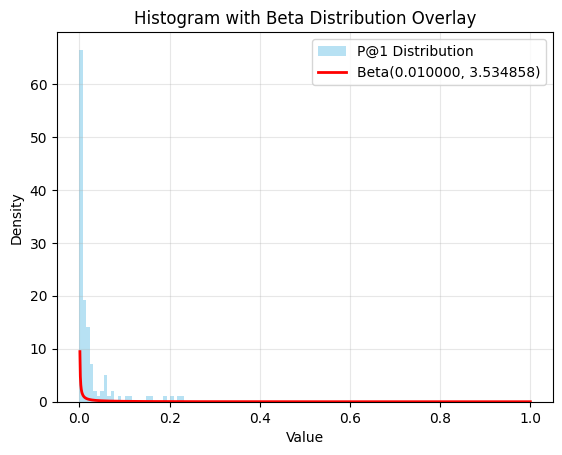

In [14]:
stats_utils.plot_histo_and_beta(pythia12_math["Score"], beta_3_params)

In [15]:
beta_3_discretized_params

alpha                 0.228083
beta                  1.570661
loc                        0.0
scale                   0.2328
neg_log_likelihood    0.763942
success                Success
dtype: object

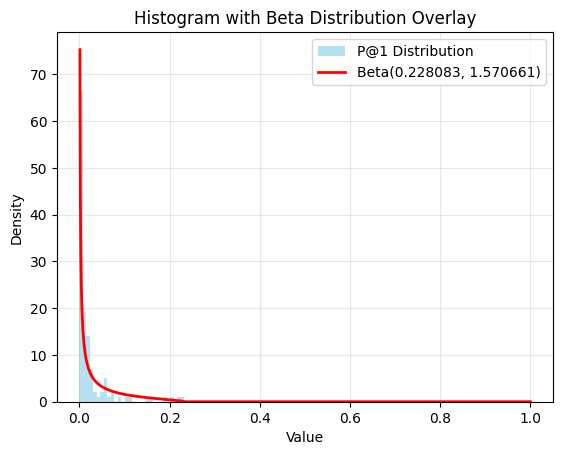

In [16]:
stats_utils.plot_histo_and_beta(pythia12_math["Score"], beta_3_discretized_params)

Now that we have observed the high-samples regime, let's look at what happens when there is only a small number of samples for each problem -- we will subsample only 20 attempts per problem and refit the distributions. Note that in order to fit the scaling law, beta is irrelevant.  Therefore, we are interested in understanding how close we can get to alpha.   

In [17]:
smaller_data = data[[]]
samples = 20
probs = pythia12_math[
    "Score"
]  # np.clip(np.random.randn(len(pythia12_math['Score'])), 0.00001, 1-0.00001)
smaller_data = {
    "Num. Samples Correct": np.random.binomial(n=samples, p=probs),
    "Num. Samples Total": np.ones(len(pythia12_math)) * samples,
}
smaller_pythia12_math = pd.DataFrame(smaller_data)
smaller_pythia12_math["Score"] = (
    smaller_pythia12_math["Num. Samples Correct"]
    / smaller_pythia12_math["Num. Samples Total"]
)

In [18]:
model_ind = individual_data[
    (individual_data["Benchmark"] == "MATH") & (individual_data["Model"] == model_name)
]
model_ind = model_ind[model_ind["Attempt Idx"] <= samples]
model_ind["Num. Samples Correct"] = model_ind.groupby("Problem Idx")["Score"].transform(
    "sum"
)
model_ind["Num. Samples Total"] = samples

In [19]:
smaller_pythia_12 = model_ind

In [20]:
np.random.binomial(n=samples, p=probs)

array([0, 1, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 2, 1, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

We refit the data using the same three methods as before.  We will take the expectation of the resulting beta binomials and see which one estimates the largest pass@k for the full data.  

In [21]:
import importlib

importlib.reload(bopt)
importlib.reload(stats_utils)
importlib.reload(mixtures)

<module 'src.mixtures' from '/Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/src/mixtures.py'>

In [22]:
# beta_3_params_stable = bopt.fit_beta_binomial_three_parameters_stable(pythia12_math)

In [23]:
smaller_beta_2_params = (
    analyze.fit_beta_binomial_two_parameters_to_num_samples_and_num_successes(
        smaller_pythia12_math
    )
)
smaller_beta_2_params_stable = bopt.fit_beta_binomial_two_parameters_stable(
    smaller_pythia12_math
)
smaller_beta_3_params = (
    analyze.fit_beta_binomial_three_parameters_to_num_samples_and_num_successes(
        smaller_pythia12_math
    )
)
smaller_beta_3_params_stable = bopt.fit_beta_binomial_three_parameters_stable(
    smaller_pythia12_math
)
smaller_beta_3_discretized_params = (
    analyze.fit_discretized_beta_three_parameters_to_num_samples_and_num_successes(
        smaller_pythia12_math
    )
)

the scale is 0.4


alpha                   0.159978
beta                    4.317092
loc                     0.000000
scale                   0.666008
neg_log_likelihood    246.576691
aic                   499.153382
bic                   507.709473
Power Law Exponent      0.159978
dtype: float64


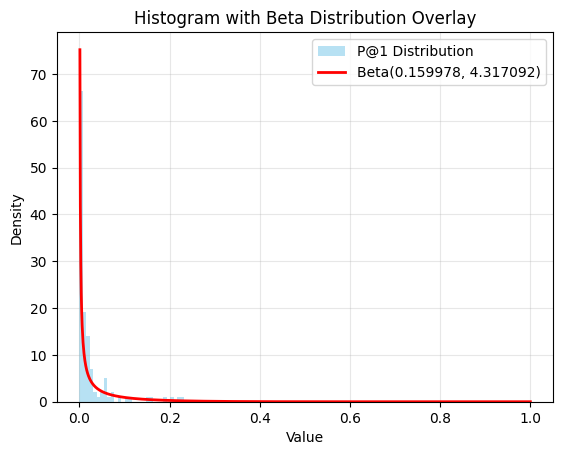

In [24]:
smaller_beta_3_params_stable = bopt.fit_beta_binomial_three_parameters_stable(
    smaller_pythia12_math
)
print(smaller_beta_3_params_stable)
stats_utils.plot_histo_and_beta(pythia12_math["Score"], smaller_beta_3_params_stable)

In [25]:
smaller_beta_2_params_stable

alpha                  0.167275
beta                   6.879056
loc                    0.000000
scale                  1.000000
neg_log_likelihood     1.926766
aic                    7.853533
bic                   13.557593
Power Law Exponent     0.167275
dtype: float64

Let's now plot the beta fit along with the entire distribution.

alpha                  0.167290
beta                   6.880272
loc                    0.000000
scale                  1.000000
neg_log_likelihood     0.837273
aic                    5.674546
bic                   11.378606
Power Law Exponent     0.167290
dtype: float64


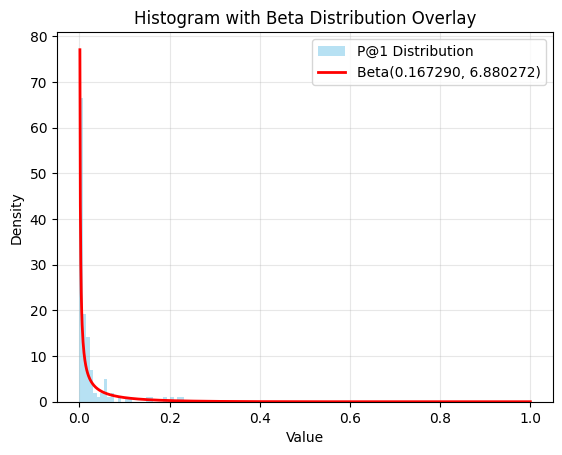

In [26]:
print(smaller_beta_2_params)
stats_utils.plot_histo_and_beta(pythia12_math["Score"], smaller_beta_2_params)

alpha                 0.142517
beta                  2.254566
loc                        0.0
scale                 0.403125
neg_log_likelihood    0.836771
maxiter                   5000
success                Success
dtype: object


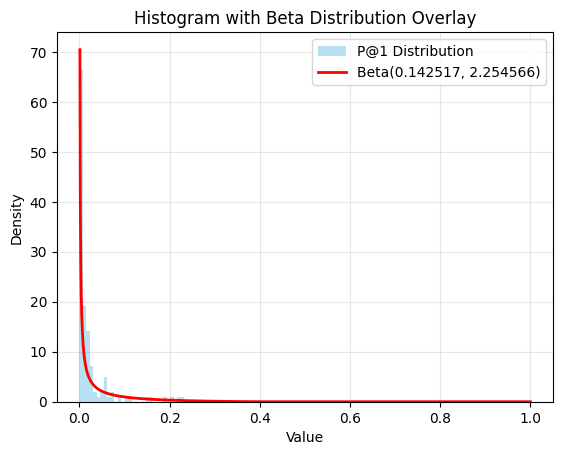

In [27]:
print(smaller_beta_3_params)
stats_utils.plot_histo_and_beta(pythia12_math["Score"], smaller_beta_3_params)

alpha                   0.159978
beta                    4.317092
loc                     0.000000
scale                   0.666008
neg_log_likelihood    246.576691
aic                   499.153382
bic                   507.709473
Power Law Exponent      0.159978
dtype: float64


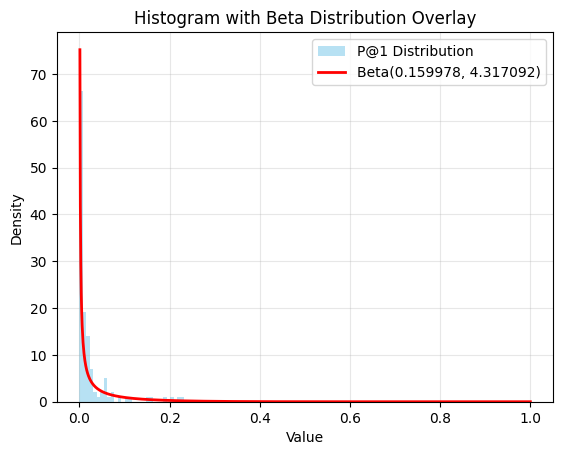

In [28]:
print(smaller_beta_3_params_stable)
stats_utils.plot_histo_and_beta(pythia12_math["Score"], smaller_beta_3_params_stable)

alpha                 0.025747
beta                  0.495783
loc                        0.0
scale                      0.4
neg_log_likelihood    0.245295
success                Success
dtype: object


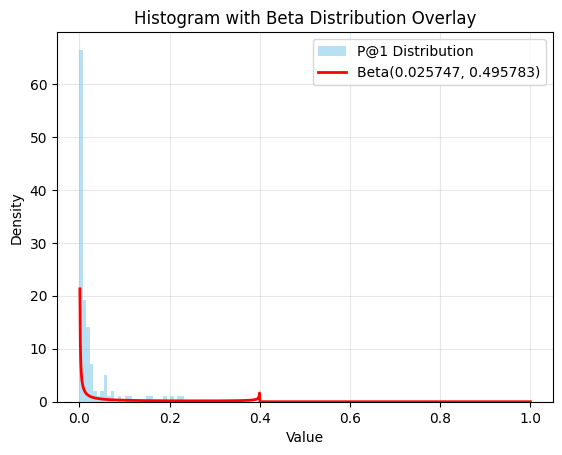

In [29]:
print(smaller_beta_3_discretized_params)
stats_utils.plot_histo_and_beta(
    pythia12_math["Score"], smaller_beta_3_discretized_params
)

Now let's measure how far off $\alpha$ is for each of these fits from the originals.

In [30]:
print(f'beta_2_params error: {beta_2_params['alpha']-smaller_beta_2_params['alpha']}')
#print(f'beta_3_params error: {beta_3_params['alpha'] - smaller_beta_3_params['alpha']}')
print(f'beta_3_discretized_error: {beta_3_discretized_params['alpha'] - smaller_beta_3_discretized_params['alpha']}')

beta_2_params error: 0.33270953906973255
beta_3_discretized_error: 0.20233639301887227


In [31]:
# p@k new
np.mean(1 - (1 - probs) ** 10000)

0.848482956420288

In [32]:
# let's compute the true pass@k
p_at_k = 1 - (len(pythia12_math[pythia12_math["Num. Samples Correct"] == 0])) / len(
    pythia12_math
)
print(f"Measured pass@k success rate: {p_at_k}")

Measured pass@k success rate: 0.875


Let's also compute the predicted pass@k for each of the predicted beta-binomials.  Specifically, we want to compute:

$1-\int_0^1 {n\choose{0}}(1-p)^k dG(p)$ where $G(p)$ is the fitted beta distribution.

Let's estimate pass@k from both the subset of data and the full data for each method

In [33]:
smaller_beta_2_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(smaller_beta_2_params["alpha"], smaller_beta_2_params["beta"]),
        scale=1.0,
        num_samples=np.array([10000]),
        num_successes=np.array([0]),
    )
)
smaller_beta_2_pass_at_10000

0.7072819099527141

In [34]:
smaller_beta_2_stable_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(
            smaller_beta_2_params_stable["alpha"],
            smaller_beta_2_params_stable["beta"],
        ),
        scale=1.0,
        num_samples=np.array([10000]),
        num_successes=np.array([0]),
    )
)
smaller_beta_2_stable_pass_at_10000

0.707258171525667

In [35]:
beta_2_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(beta_2_params["alpha"], beta_2_params["beta"]),
        scale=1.0,
        num_samples=np.array([10000]),
        num_successes=np.array([0]),
    )
)
beta_2_pass_at_10000

0.9819488664002083

In [36]:
smaller_beta_2_pass_at_10000_stable = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(
            smaller_beta_2_params_stable["alpha"],
            smaller_beta_2_params_stable["beta"],
        ),
        scale=1.0,
        num_samples=np.array([10000]),
        num_successes=np.array([0]),
    )
)
smaller_beta_2_pass_at_10000_stable

0.707258171525667

This is strange!  The data fit on the subset is a better estimator of the true pass@k than the data fit on the entire set

In [37]:
smaller_beta_3_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(smaller_beta_3_params["alpha"], smaller_beta_3_params["beta"]),
        scale=smaller_beta_3_params["scale"],
        num_samples=np.array([10000]),
        num_successes=np.array([0]),
    )
)
smaller_beta_3_pass_at_10000

0.6657065290141064

In [38]:
beta_3_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(beta_3_params["alpha"], beta_3_params["beta"]),
        scale=beta_3_params["scale"],
        num_samples=np.array([10000]),
        num_successes=np.array([0]),
    )
)
beta_3_pass_at_10000

0.07775471776458209

In [39]:
def compute_estimate(params, k):
    return 1 - np.exp(
        -1
        * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
            params=(params["alpha"], params["beta"]),
            scale=params["scale"],
            num_samples=np.array([k]),
            num_successes=np.array([0]),
        )
    )


def compute_estimate_stable(params, k):
    return 1 - np.exp(
        -1
        * bopt.compute_beta_binomial_three_parameter_nll_single(
            (params["alpha"], params["beta"], params["scale"]), k, 0
        )
    )


def compute_p_at_ks(data, ks):
    pass_at_ks = analyze.compute_pass_at_k_from_num_samples_and_num_successes_df(
        data, ks
    )
    pass_at_ks = pass_at_ks.groupby(by="Scaling Parameter").mean()
    return np.array(pass_at_ks["Score"])

In [40]:
ks = np.array([50, 100, 1000, 10000])
beta_estimates = [
    compute_estimate(smaller_beta_3_discretized_params, k)
    for k in [50, 100, 1000, 10000]
]
pass_at_ks = compute_p_at_ks(pythia12_math, ks)
np.mean((beta_estimates - pass_at_ks) ** 2)

0.22345056261423973

In [41]:
ks = np.array([50, 100, 1000, 10000])
beta_3_stable_estimates = [
    compute_estimate(smaller_beta_3_params_stable, k) for k in [50, 100, 1000, 10000]
]
pass_at_ks = compute_p_at_ks(pythia12_math, ks)
np.mean((beta_3_stable_estimates - pass_at_ks) ** 2)

0.0192455342539937

In [42]:
beta_3_stable_estimates

[0.30213791808810997,
 0.37019951678941154,
 0.5608543953195955,
 0.6959275731954524]

In [43]:
smaller_beta_3_discrete_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(
            smaller_beta_3_discretized_params["alpha"],
            smaller_beta_3_discretized_params["beta"],
        ),
        scale=smaller_beta_3_params["scale"],
        num_samples=np.array([10000]),
        num_successes=np.array([0]),
    )
)
smaller_beta_3_discrete_pass_at_10000

0.23143141029096947

In [44]:
# the better estimator:
try:
    discrete_at_9900 = 1 - np.exp(
        -1
        * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
            params=(
                smaller_beta_3_discretized_params["alpha"],
                smaller_beta_3_discretized_params["beta"],
            ),
            scale=smaller_beta_3_params["scale"],
            num_samples=np.array([1e5 - samples]),
            num_successes=np.array([0]),
        )
    )
    print(
        (
            discrete_at_9900
            * len(
                smaller_pythia12_math[
                    smaller_pythia12_math["Num. Samples Correct"] == 0
                ]
            )
            + len(
                smaller_pythia12_math[
                    smaller_pythia12_math["Num. Samples Correct"] != 0
                ]
            )
        )
        / len(smaller_pythia12_math)
    )

except:
    pass

In [45]:
# the better estimator:
try:
    discrete_fail_100 = np.exp(
        -1
        * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
            params=(
                smaller_beta_3_discretized_params["alpha"],
                smaller_beta_3_discretized_params["beta"],
            ),
            scale=smaller_beta_3_params["scale"],
            num_samples=np.array([samples]),
            num_successes=np.array([0]),
        )
    )
    discrete_fail_10000 = np.exp(
        -1
        * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
            params=(
                smaller_beta_3_discretized_params["alpha"],
                smaller_beta_3_discretized_params["beta"],
            ),
            scale=smaller_beta_3_params["scale"],
            num_samples=np.array([1e5]),
            num_successes=np.array([0]),
        )
    )
    print(
        (
            len(smaller_pythia12_math) * (discrete_fail_100 - discrete_fail_10000)
            + len(
                smaller_pythia12_math[
                    smaller_pythia12_math["Num. Samples Correct"] != 0
                ]
            )
        )
        / len(smaller_pythia12_math)
    )
except:
    pass

In [46]:
fail_all = (
    analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(
            smaller_beta_3_discretized_params["alpha"],
            smaller_beta_3_discretized_params["beta"],
        ),
        scale=smaller_beta_3_params["scale"],
        num_samples=np.array([pythia12_math["Num. Samples Total"].max()]),
        num_successes=np.array([0]),
    )
)
fail_first = (
    analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(
            smaller_beta_3_discretized_params["alpha"],
            smaller_beta_3_discretized_params["beta"],
        ),
        scale=smaller_beta_3_params["scale"],
        num_samples=np.array([smaller_pythia12_math["Num. Samples Total"].max()]),
        num_successes=np.array([0]),
    )
)
succeed_first = len(
    smaller_pythia12_math[smaller_pythia12_math["Num. Samples Correct"] != 0]
)
fail_first_true = len(smaller_pythia12_math) - succeed_first
questions = len(smaller_pythia12_math)
print(succeed_first / questions)
best_estimate = (
    (fail_first_true - fail_all * questions) / fail_first_true + succeed_first
) / questions
best_estimate

0.2109375


0.21614380724182597

In [47]:
beta_3_discrete_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(beta_3_discretized_params["alpha"], beta_3_discretized_params["beta"]),
        scale=beta_3_discretized_params["scale"],
        num_samples=np.array([10000]),
        num_successes=np.array([0]),
    )
)
beta_3_discrete_pass_at_10000

0.8216253653955078

Rylan claimed that the pass@k estimates for the discretized distribution were superior.  Based on this analysis, the standard beta binomial estimator seems to work better.  There are many more models and datasets that one could analyze, though.  Maybe this observation doesn't hold widely across models.  It does seem fairly spectacular that with just 10 samples per problem we are able to estimate pass@k using this method within 2%.  

In [48]:
smaller_pythia12_math

,Num. Samples Correct,Num. Samples Total,Score
0,1,20.0,0.05
1,0,20.0,0.00
2,1,20.0,0.05
3,0,20.0,0.00
4,4,20.0,0.20
...,...,...,...
123,2,20.0,0.10
124,0,20.0,0.00
125,0,20.0,0.00
126,0,20.0,0.00


Finally, let's look at the original estimator developed for fitting power laws.

In [49]:
# original estimator
ks_fit = np.array([i for i in range(1, samples)])
pass_at_ks = analyze.compute_pass_at_k_from_num_samples_and_num_successes_df(
    smaller_pythia12_math, ks_fit
)
pass_at_ks = pass_at_ks.groupby("Scaling Parameter")["Score"].mean()
model = LinearRegression(fit_intercept=True)
model.fit(np.log(ks_fit).reshape(-1, 1), -np.log(pass_at_ks))
np.exp(-model.predict(np.log([10000]).reshape(-1, 1)))

array([18.08715428])

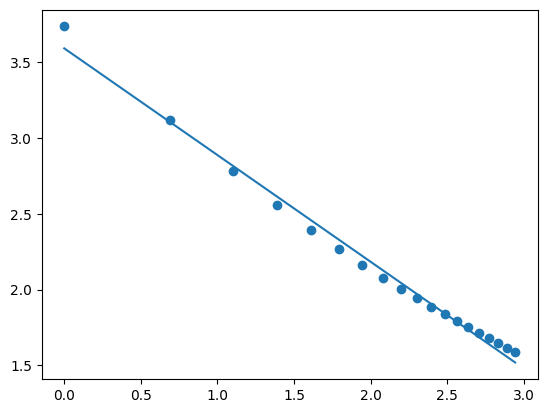

In [50]:
plt.scatter(np.log(ks_fit), -np.log(pass_at_ks))
plt.plot(np.log(ks_fit), model.predict(np.log(ks_fit).reshape(-1, 1)))

In [51]:
model.intercept_

3.592396651818029


Define $\eta_x = \mathbb{E}[n_x]$, or the expected number of samples observed $x$ times in the first $[-k, 0)$ trials (we write this as a continuous interval to be consistent with Efron, but really it is $\{-k, -k+1,...,-1\})$.

Under our model using Efron's notation, $$\eta_x = S\int_0^1 {k\choose{x}} p^x(1-p)^{k-x} dG(p)$$.
Let $t= n/k<1$, i.e. the number of new samples divided by the number of samples taken so far.  We also will need to assume that all of the probabilities are small in the sense that $(1-p_i)^n \approx (1-np_i)$ for all probabilities and $(1-p_i)^k \approx (1-p_i)^n$.  This is an obviously unrealistic assumption in our case.  We want to estimate the number of additional problems that we will solve at least once if we take $n$ additional samples.  In expectation, this is given by $$\Delta_{t}(x) = S\int_0^1 (1-p)^k(1-(1-p)^n)dG(p).$$  

We can rewrite this as 
$$ \Delta_t(x) = S \int_0^1 (1-p)^k-(1-p)^{n}(1-p)^{k} \\ = \eta_0 - S\int_0^1 (1-p)^{n+k}.$$

We use Poisson approximation in order to resolve the second term in terms of $\eta_x$.  First, we need to assume a low time horizon, i.e. $0<t<1$ and small p.  Under these assumptions, we get

$$  \sum_{i=0}^{n+k} {n+k\choose{i}}(-p)^i \\ = \sum_{i=0}^{k} {k\choose{i}}(-p)^i (1-p)^{n-i} \\ \approx \sum_{i=0}^k {k\choose{i}}(-p)^i (1-p)^{k-i}.$$

If one integrates this expression over the distribution of probabilities, one recovers $\eta_0 - \sum (-1)^i \eta_i$.


In [52]:
stats_utils.compute_efron_estimator(smaller_pythia12_math, predicted_samples=980 / 20)

6533145.7109375

More stable versions of Efron?

In [53]:
import math

final_samples = 1e4 / samples
highest = smaller_pythia12_math["Num. Samples Correct"].max()
total = 0
for y in range(1, samples):
    xi_y = 0
    u = 2 / (final_samples - 1)
    for j in range(1, y + 1):
        xi_y += (
            math.comb(y, j)
            * (-1) ** (j + 1)
            / 2**y
            * len(
                smaller_pythia12_math[
                    smaller_pythia12_math["Num. Samples Correct"] == j
                ]
            )
        )
    total += u**y * xi_y
print(total)

0.030168868260352


In [54]:
len(smaller_pythia12_math[smaller_pythia12_math["Num. Samples Correct"] != 0]) / len(
    smaller_pythia12_math
)

0.2109375

In [55]:
def compute_bin_estimator(data, predicted_samples):
    largest_success_rate = data["Num. Samples Correct"].max()
    total = 0
    for i in range(1, largest_success_rate):
        term = len(data[data["Num. Samples Correct"] == i]) * (-1) ** (i + 1)
        total += term

    total += len(data[data["Num. Samples Correct"] != 0])
    total /= len(data)
    return total


compute_bin_estimator(smaller_pythia12_math, predicted_samples=0)

0.3359375

In [56]:
import importlib

importlib.reload(bopt)
importlib.reload(stats_utils)
importlib.reload(mixtures)
importlib.reload(EM)

<module 'src.EM' from '/Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/src/EM.py'>

In [57]:
n_distr = 1
beta_mixture = BEM.beta_binom_mixture(
    n_distr=n_distr,
    num_successes=smaller_pythia12_math["Num. Samples Correct"],
    num_trials=smaller_pythia12_math["Num. Samples Total"],
)
beta_mixture_params = beta_mixture.fit_mixture()
# beta_mixture_params = EM.fit_beta_binomial_mixture_em(smaller_pythia12_math['Num. Samples Total'], smaller_pythia12_math['Num. Samples Correct'], n_distr)

0: nll: 107.17093062812748
0: nll: 107.17092958986379
0: nll: 107.17092958492135
0: nll: 107.17092958207927
0: nll: 107.17092957944921
0: nll: 107.17092955398593
0: nll: 107.17092952156048
0: nll: 107.17092951906899
0: nll: 107.17092951662686
0: nll: 107.17092951283959
0: nll: 107.17092950920417
0: nll: 107.17092940435963
0: nll: 107.17092928719109
0: nll: 107.17092927521065
0: nll: 107.1709292663482
0: nll: 107.17092926213849
0: nll: 107.17092925380928
0: nll: 107.1709292382408
0: nll: 107.17092921999038
0: nll: 107.17092908706618
0: nll: 107.17092897110828
0: nll: 107.17092896196202
0: nll: 107.17092895364769
0: nll: 107.17092894599669
0: nll: 107.17092894127424
0: nll: 107.17092893877427
0: nll: 107.1709289352393
0: nll: 107.17092893329173
0: nll: 107.17092892984684
0: nll: 107.17092892664452
0: nll: 107.17092892302067
0: nll: 107.17092891808599
0: nll: 107.17092891209793
0: nll: 107.17092890829653
0: nll: 107.17092890245601
0: nll: 107.17092878789896
0: nll: 107.17092867584518
0: n

In [58]:
print(beta_mixture_params)

{'alpha_0': 0.16745463618037318, 'beta_0': 6.883214630442696, 'pi_0': 1.0}


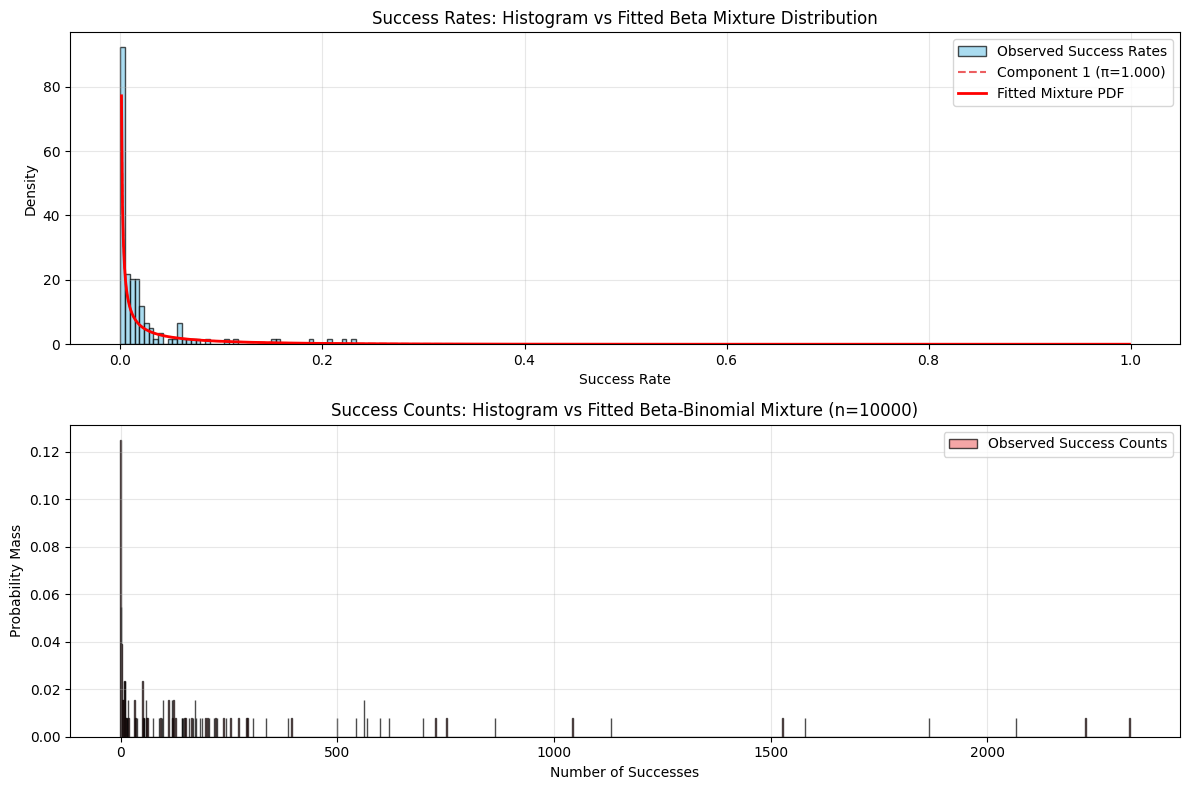

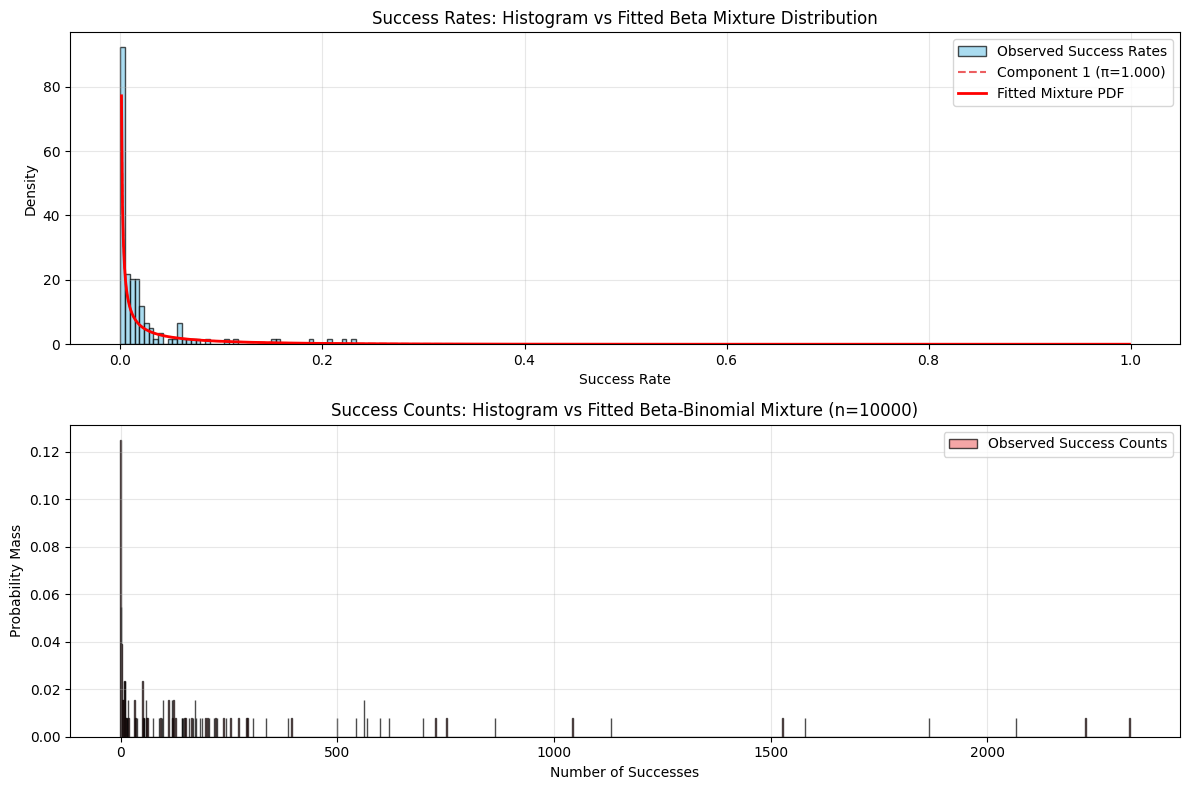

In [59]:
mixtures.plot_beta_binomial_mixture_with_histogram(
    pythia12_math, beta_mixture_params, n_distr
)

In [60]:
# beta_mixture_params['pi_0'] =1
probs = [beta_mixture_params[f"pi_{i}"] for i in range(n_distr - 1)]
probs = np.array(probs + [1 - sum(probs)])
log_probs = bopt.compute_component_log_pmfs(
    0, 10000, beta_mixture_params, n_distr=n_distr
) + np.log(probs)
1 - np.exp(scipy.special.logsumexp(log_probs))

0.7076117768922869

In [61]:
expected = EM.compute_expected_pass_at_k(beta_mixture_params, n_distr, samples, 10000)
expected + len(
    smaller_pythia12_math[smaller_pythia12_math["Num. Samples Correct"] != 0]
) / len(pythia12_math)

0.7085666257402722

In [62]:
expected = EM.compute_expected_pass_at_k(beta_mixture_params, n_distr, samples, 10000)
expected + len(
    smaller_pythia12_math[smaller_pythia12_math["Num. Samples Correct"] != 0]
) / len(pythia12_math)

0.7085666257402722

In [63]:
expected = EM.compute_expected_pass_at_k(
    beta_mixture_params, n_distr, 0, 10000 - samples
) * len(smaller_pythia12_math[smaller_pythia12_math["Num. Samples Correct"] == 0])
(
    expected
    + len(smaller_pythia12_math[smaller_pythia12_math["Num. Samples Correct"] != 0])
) / len(pythia12_math)

0.7692101096341437

In [64]:
num_samples_total = pythia12_math["Num. Samples Total"].max()
fail_all_mixture = 1 - EM.compute_expected_pass_at_k(
    beta_mixture_params, n_distr, 0, num_samples_total
)
# fail_first = analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(params = (smaller_beta_3_discretized_params['alpha'], smaller_beta_3_discretized_params['beta']), scale = smaller_beta_3_params['scale'], num_samples = np.array([smaller_pythia12_math['Num. Samples Total'].max()]), num_successes = np.array([0]) )
succeed_first = len(
    smaller_pythia12_math[smaller_pythia12_math["Num. Samples Correct"] != 0]
)
fail_first_true = len(smaller_pythia12_math) - succeed_first
questions = len(smaller_pythia12_math)
best_estimate = ((questions - fail_all_mixture * fail_first_true)) / questions
best_estimate

0.7692874177020398

In [65]:
def compute_estimates_better_mixture(data, params, k, n_distr):
    unsolved = 1 - EM.compute_expected_pass_at_k(beta_mixture_params, n_distr, 0, k)
    fail_first_true = len(data[data["Num. Samples Correct"] == 0])
    questions = len(data)
    estimate = (questions - fail_first_true * unsolved) / questions
    return estimate

In [66]:
def compute_estimates_three_param(data, params, k):
    expected_p_at_k = np.exp(
        -1
        * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
            (params["alpha"], params["beta"]),
            scale=params["scale"],
            num_samples=np.array([k]),
            num_successes=np.array([0]),
        )
    )
    unsolved = expected_p_at_k
    print(unsolved)
    fail_first_true = len(data[data["Num. Samples Correct"] == 0])
    questions = len(data)
    estimate = (questions - fail_first_true * unsolved) / questions
    return estimate

In [67]:
ks = np.array([50, 100, 1000, 10000])
beta_3_stable_estimates_better = [
    compute_estimates_three_param(
        smaller_pythia12_math, smaller_beta_3_params_stable, k
    )
    for k in ks
]
pass_at_ks = compute_p_at_ks(pythia12_math, ks)
np.mean((beta_3_stable_estimates_better - pass_at_ks) ** 2)

0.69786208191189
0.6298004832105885
0.4391456046804046
0.30407242680454755


0.006019003840984909

get estimates for the stable beta 3

In [68]:
ks = np.array([50, 100, 1000, 10000])
beta_3_stable_estimates = [
    compute_estimate(smaller_beta_3_params_stable, k) for k in [50, 100, 1000, 10000]
]
pass_at_ks = compute_p_at_ks(pythia12_math, ks)
np.mean((beta_3_stable_estimates - pass_at_ks) ** 2)

0.0192455342539937

In [69]:
mixture_estimates = [
    compute_estimates_better_mixture(
        smaller_pythia12_math, beta_mixture_params, k, n_distr
    )
    for k in ks
]

In [70]:
mixture_estimates

[0.4509778770907348,
 0.5062921108653754,
 0.6610745845198982,
 0.7692874177020398]

In [71]:
# chao's estimator
fraction_solved_1 = smaller_pythia12_math[
    smaller_pythia12_math["Num. Samples Correct"] == 1
].count()  # /len(smaller_pythia12_math)

In [72]:
fraction_solved_2 = smaller_pythia12_math[
    smaller_pythia12_math["Num. Samples Correct"] == 2
].count()  # /len(smaller_pythia12_math)

In [73]:
(
    smaller_pythia12_math[smaller_pythia12_math["Num. Samples Correct"] != 0].count()
    + fraction_solved_1 * (fraction_solved_1 - 1) / (2 * (fraction_solved_2 + 1))
) / len(smaller_pythia12_math)

Num. Samples Correct    0.416016
Num. Samples Total      0.416016
Score                   0.416016
dtype: float64

In [74]:
def good_turing(data):
    largest_success_rate = data["Num. Samples Correct"].max()
    total = 0
    for i in range(largest_success_rate + 1):
        solved_i = len(data[data["Num. Samples Correct"] == i])
        solved_iadd1 = len(data[data["Num. Samples Correct"] == i + 1])
        smoothed_n_i = (i + 1) * solved_iadd1 / solved_i
        print(smoothed_n_i)
        if i < 3:
            p_hat_i = i / samples  # smoothed_n_i / data['Num. Samples Total'].max()
        else:
            p_hat_i = i / samples
        total += solved_i * (1 - (1 - p_hat_i) ** 1e5)
    return total, total / len(data)

In [75]:
try:
    good_turing(smaller_pythia12_math)
except:
    pass

0.1485148514851485
0.4
3.0
2.6666666666666665
7.5
0.0


In [76]:
model

LinearRegression()

In [77]:
X = ks.reshape(-1, 1)
regression_predictions = np.exp(-model.predict(np.log(X)))

In [78]:
regression_predictions

array([ 0.43307785,  0.70567722,  3.57263108, 18.08715428])

In [79]:
individual_data[
    (individual_data["Model"] == model_name) & (individual_data["Problem Idx"] == 82)
]

,Problem Idx,Attempt Idx,Score,Benchmark,Model
7680000,82,1,0.0,MATH,Pythia 12B
7680128,82,2,0.0,MATH,Pythia 12B
7680256,82,3,0.0,MATH,Pythia 12B
7680384,82,4,0.0,MATH,Pythia 12B
7680512,82,5,0.0,MATH,Pythia 12B
...,...,...,...,...,...
8959360,82,9996,0.0,MATH,Pythia 12B
8959488,82,9997,0.0,MATH,Pythia 12B
8959616,82,9998,0.0,MATH,Pythia 12B
8959744,82,9999,0.0,MATH,Pythia 12B


In [80]:
individual_data_model = individual_data[(individual_data["Model"] == model_name)]

In [81]:
heap = []
heapq.heapify(heap)
budget = samples * len(pythia12_math)
results = []
for ele in individual_data_model["Problem Idx"].unique():
    heapq.heappush(heap, (0, ele))
total_samples = 0
while total_samples < budget:
    total_samples += 1
    attempts, index = heapq.heappop(heap)
    attempt_index = attempts + 1

    # Check if this attempt exists
    filtered_data = individual_data_model[
        (individual_data_model["Problem Idx"] == index)
        & (individual_data_model["Attempt Idx"] == attempt_index)
    ]

    if filtered_data.empty:
        continue  # Skip if no data for this attempt

    score = filtered_data["Score"].iloc[0]
    attempts += 1

    if score == 0:
        heapq.heappush(heap, (attempts, index))  # Fixed: use 'index' not 'ele'
    else:
        results.append(
            {
                "Problem Idx": index,
                "Num. Samples Total": attempts,
                "Num. Samples Correct": 1,
            }
        )
while heap:
    attempts, index = heapq.heappop(heap)
    results.append(
        {
            "Problem Idx": index,
            "Num. Samples Total": attempts,
            "Num. Samples Correct": 0,
        }
    )
efficient_data = pd.DataFrame(results)

In [82]:
import importlib

importlib.reload(bopt)
importlib.reload(stats_utils)
importlib.reload(mixtures)
importlib.reload(BEM)
importlib.reload(EM)
importlib.reload(bemg)

<module 'src.bem_geometric' from '/Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/src/bem_geometric.py'>

In [83]:
n_distr = 1
geom_mix = bemg.beta_geometric_mixture(
    n_distr=n_distr,
    num_successes=efficient_data["Num. Samples Correct"],
    num_trials=efficient_data["Num. Samples Total"],
)
geom_params = geom_mix.fit_mixture()

0: nll: 171.84755195360987
0: nll: 171.8475513741189
0: nll: 171.84755137411787
0: nll: 171.8475513740728
0: nll: 171.84755137407163
0: nll: 171.84755137407052
0: nll: 171.8475513734703
0: nll: 171.84755137008747
0: nll: 171.84755136999394
0: nll: 171.84755136981278
0: nll: 171.84755136981235
0: nll: 171.84755136876203
0: nll: 171.8475513687439
0: nll: 171.84755136864942
0: nll: 171.84755136828193
0: nll: 171.84755136826135
0: nll: 171.84755136824933
0: nll: 171.8475513682418
0: nll: 171.84755136793135
0: nll: 171.8475513678331
0: nll: 171.8475513678115
0: nll: 171.84755136779594
0: nll: 171.84755136779572
0: nll: 171.8475513677738
0: nll: 171.84755136774191
0: nll: 171.84755136770497
0: nll: 171.84755136767274
0: nll: 171.84755136764664
0: nll: 171.84755136761424
0: nll: 171.8475513675947
0: nll: 171.84755136753623
0: nll: 171.84755136748754
0: nll: 171.84755136747097
0: nll: 171.8475513674477
0: nll: 171.84755136737792
0: nll: 171.84755136732332
0: nll: 171.84755136125816
0: nll: 171

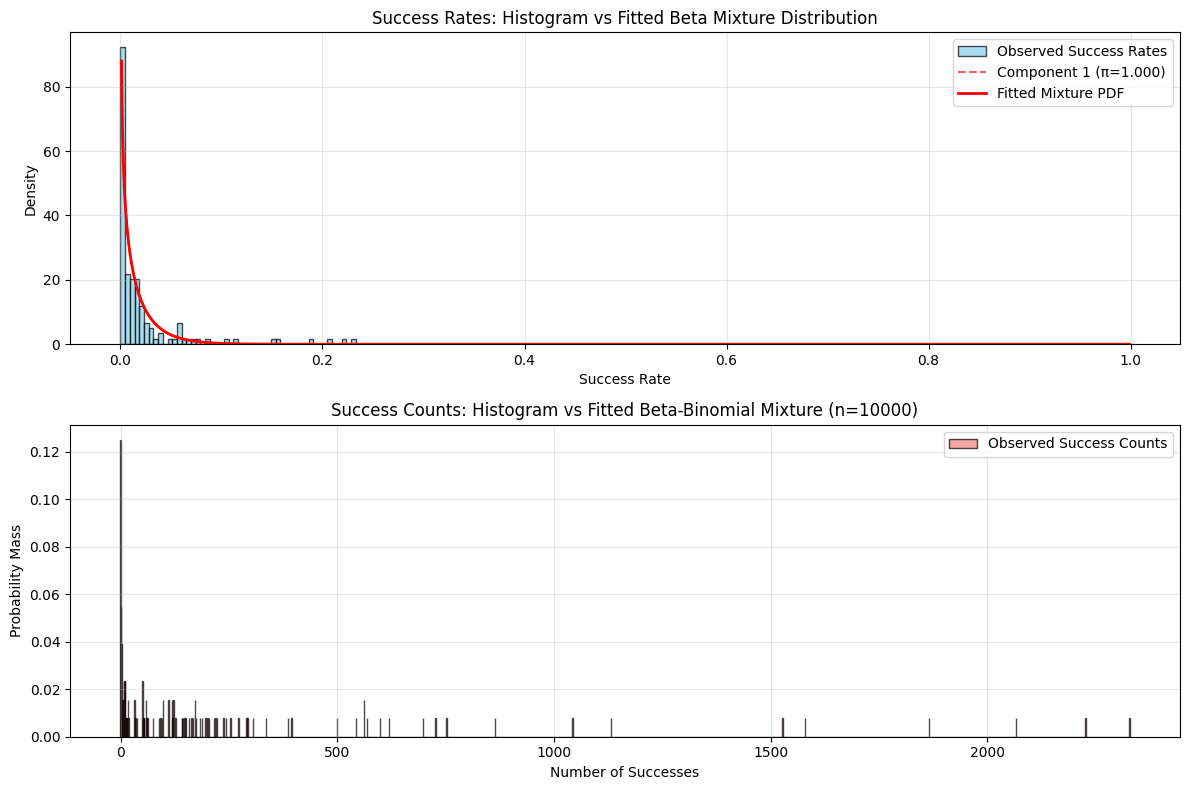

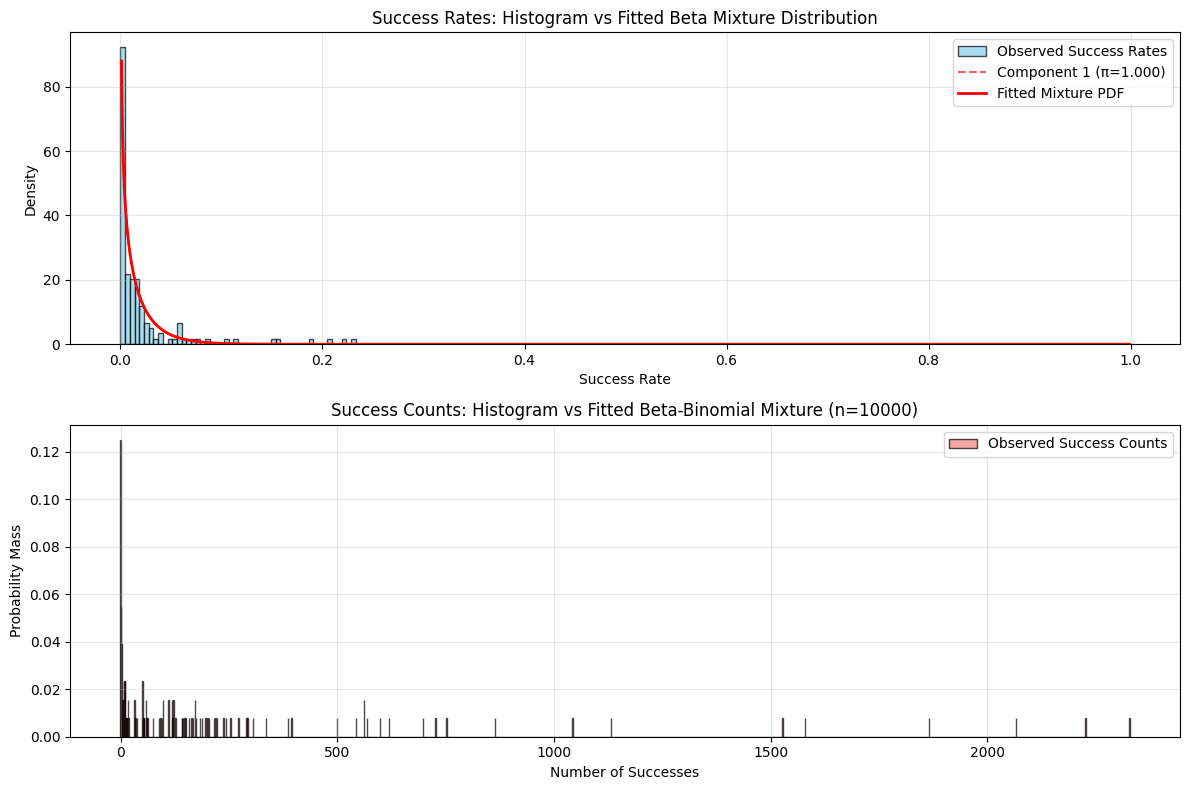

In [84]:
mixtures.plot_beta_binomial_mixture_with_histogram(pythia12_math, geom_params, n_distr)

In [85]:
1 - len(efficient_data[efficient_data["Num. Samples Correct"] == 0]) / len(
    efficient_data
)

0.25

In [86]:
1 - len(
    smaller_pythia12_math[smaller_pythia12_math["Num. Samples Correct"] == 0]
) / len(smaller_pythia12_math)

0.2109375

In [87]:
efficient_estimate = EM.compute_expected_pass_at_k(
    geom_params, n_distr, 0, num_samples_total
)
efficient_estimate

0.9709864560781113

In [88]:
geom_reformatted = {
    "alpha": geom_params["alpha_0"],
    "beta": geom_params["beta_0"],
    "scale": 1.0,
}
efficient_beta_binomial = [compute_estimate(geom_reformatted, k) for k in ks]

In [89]:
pass_at_ks = compute_p_at_ks(pythia12_math, ks)

In [90]:
geom_correct_estimates = [
    bemg.compute_estimates_better_mixture_geometric(
        efficient_data, geom_params, k, n_distr
    )
    for k in ks
]

In [91]:
import importlib

importlib.reload(bopt)
importlib.reload(stats_utils)
importlib.reload(mixtures)
importlib.reload(BEM)
importlib.reload(EM)
importlib.reload(bemg)

<module 'src.bem_geometric' from '/Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/src/bem_geometric.py'>

In [92]:
smaller_beta_3_params_geometric_stable = bopt.fit_beta_binomial_three_parameters_stable(
    efficient_data
)
three_param_geom_estimates = [
    bemg.compute_estimates_better_three_param_geometric(
        efficient_data, smaller_beta_3_params_geometric_stable, k
    )
    for k in ks
]

In [93]:
smaller_beta_3_params_geometric_stable

alpha                   0.624002
beta                   12.529401
loc                     0.000000
scale                   0.322033
neg_log_likelihood    171.857738
aic                   349.715477
bic                   358.271568
Power Law Exponent      0.624002
dtype: float64

In [94]:
three_param_geom_estimates

[0.4024117996111576,
 0.5488937754879264,
 0.8723628307756045,
 0.9690439739324826]

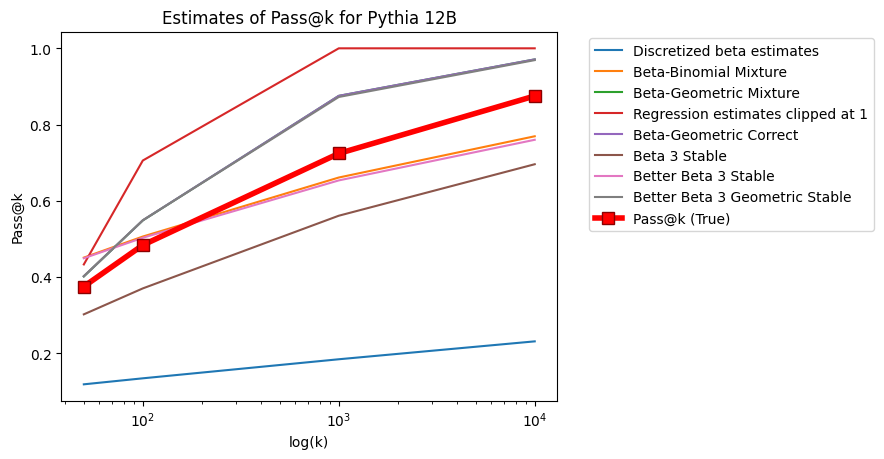

In [95]:
plt.plot(ks, beta_estimates, label="Discretized beta estimates")
plt.plot(ks, mixture_estimates, label="Beta-Binomial Mixture")
plt.plot(ks, efficient_beta_binomial, label="Beta-Geometric Mixture")
plt.plot(
    ks, np.clip(regression_predictions, 0, 1), label="Regression estimates clipped at 1"
)
plt.plot(ks, np.clip(geom_correct_estimates, 0, 1), label="Beta-Geometric Correct")
plt.plot(ks, beta_3_stable_estimates, label="Beta 3 Stable")
plt.plot(ks, beta_3_stable_estimates_better, label="Better Beta 3 Stable")
plt.plot(ks, three_param_geom_estimates, label="Better Beta 3 Geometric Stable")
plt.plot(
    ks,
    pass_at_ks,
    label="Pass@k (True)",
    linewidth=4,
    color="red",
    linestyle="-",
    marker="s",
    markersize=8,
    markerfacecolor="red",
    markeredgecolor="darkred",
)
plt.title(f"Estimates of Pass@k for {model_name}")
plt.ylabel("Pass@k")
plt.xlabel("log(k)")
plt.xscale("log")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")